In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score , accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [57]:
data = pd.read_csv('Online Retail.csv')

In [58]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Time'] = data['InvoiceDate'].dt.strftime('%H:%M:%S')
data['Hour'] = data['InvoiceDate'].dt.hour
data['TimeOfDay'] = ['Early Morning' if x < 6 else ('Morning' if x < 12 else ('Noon' if x < 14 else ('Afternoon' if x < 18 else ('Evening' if x < 22 else 'Night')))) for x in data['Hour']]
data['Spent'] = data['Quantity'] * data['UnitPrice']
data['Transaction_type'] = data['Quantity'].apply(lambda x: 'Sold' if x < 0 else 'Bought')

In [59]:
data.dropna(inplace=True)
data['Quantity'].fillna(data['Quantity'].mean(), inplace=True)
data['UnitPrice'].fillna(data['UnitPrice'].mean(), inplace=True)
data['InvoiceNo'].fillna('Unknown', inplace=True)
data['Description'].fillna('Unknown', inplace=True)
data['Country'].fillna('Unknown', inplace=True)
data['TimeOfDay'].fillna('Unknown', inplace=True)
data['Hour'].fillna(data['Hour'].mean(), inplace=True)
data['Weekday'].fillna(data['Weekday'].mean(), inplace=True)
data['Spent'].fillna(data['Spent'].mean(), inplace=True)
data['Transaction_type'].fillna('Unknown', inplace=True)

In [60]:
#total quantity by description
quantity_by_description = data.groupby('Description')['Quantity'].sum().reset_index()
quantity_by_description.rename(columns={'Quantity': 'QuantityByDescription'}, inplace=True)

# total spent by each invoice
total_spent_by_invoice = data.groupby('InvoiceNo')['Spent'].sum().reset_index()
total_spent_by_invoice.rename(columns={'Spent': 'TotalSpentByInvoice'}, inplace=True)

# total quantity by country and product
country_product_sales = data.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()
country_product_sales.rename(columns={'Quantity': 'CountryProductSales'}, inplace=True)

# total no of unique ccountries per product
countries_per_product = data.groupby('Description')['Country'].nunique().reset_index()
countries_per_product.rename(columns={'Country': 'NoOfuniqueCountries'}, inplace=True)

# frequency of a product bought by description and country
product_country_freq = data.groupby(['Description', 'Country']).size().reset_index(name='Frequency')


# Merge total quantity by description back to the original data
data = data.merge(quantity_by_description, on='Description', how='left')

# Merge total spent by invoice back to the original data
data = data.merge(total_spent_by_invoice, on='InvoiceNo', how='left')

# Merge total quantity by country and product back to the original data
data = data.merge(country_product_sales, on=['Country', 'Description'], how='left')

# Merge the number of countries per product back to the original data
data = data.merge(countries_per_product, on='Description', how='left')

# Merge this frequency information back into the original dataframe
data = data.merge(product_country_freq, on=['Description', 'Country'], how='left')


data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,...,Time,Hour,TimeOfDay,Spent,Transaction_type,QuantityByDescription,TotalSpentByInvoice,CountryProductSales,NoOfuniqueCountries,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,15.30,Bought,21989.0,139.12,21145.0,13,1400
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,20.34,Bought,1267.0,139.12,1217.0,4,216
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,22.00,Bought,1371.0,139.12,1052.0,4,203
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,20.34,Bought,1661.0,139.12,1649.0,3,235
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,20.34,Bought,1936.0,139.12,1914.0,4,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269256,560555,21933,PINK VINTAGE PAISLEY PICNIC BAG,1.0,2011-07-19 13:01:00,1.65,14178.0,United Kingdom,2011.0,7.0,...,13:01:00,13.0,Noon,1.65,Bought,1877.0,12.32,1480.0,8,229
269257,560555,22834,HAND WARMER BABUSHKA DESIGN,2.0,2011-07-19 13:01:00,2.10,14178.0,United Kingdom,2011.0,7.0,...,13:01:00,13.0,Noon,4.20,Bought,4140.0,12.32,3924.0,6,238
269258,560555,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1.0,2011-07-19 13:01:00,2.95,14178.0,United Kingdom,2011.0,7.0,...,13:01:00,13.0,Noon,2.95,Bought,21989.0,12.32,21145.0,13,1400
269259,560555,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,12.0,2011-07-19 13:01:00,0.18,14178.0,United Kingdom,2011.0,7.0,...,13:01:00,13.0,Noon,2.16,Bought,2689.0,12.32,2641.0,3,26


In [61]:
# Initialize LabelEncoders for categorical columns
le_weekday = LabelEncoder()
le_hour = LabelEncoder()
le_customer_id = LabelEncoder()
le_invoice_no = LabelEncoder()

# Fit and transform the categorical columns
data['Weekday'] = le_weekday.fit_transform(data['Weekday'])
data['Hour'] = le_hour.fit_transform(data['Hour'])
data['CustomerID'] = le_customer_id.fit_transform(data['CustomerID'])
data['InvoiceNo'] = le_invoice_no.fit_transform(data['InvoiceNo'])
data['Country'] = le_country.fit_transform(data['Country'])


features = ['Quantity', 'Spent' , 'TotalSpentByInvoice' , 'Weekday' , 'Hour' , 'CustomerID' , 'InvoiceNo', 'Country']
target = 'TimeOfDay'

le_target = LabelEncoder()
data[target] = le_target.fit_transform(data[target])


X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {np.mean(cv_scores):.2f}')


y_pred = model.predict(X_test)

accuracy = np.mean(cv_scores)
print('Accuracy:',accuracy)

cf = confusion_matrix(y_test, y_pred)
print('Confusion matrix \n :',cf)

target_names = [str(cls) for cls in le_target.classes_]

cr=classification_report(y_test, y_pred, target_names=target_names)
print('Classification report :',cr)

y_pred = y_pred.flatten()
y_test_values = y_test.values

result = pd.DataFrame({
    'Date': data.index[-len(y_test):],
    'Actual': y_test_values,
    'Predicted': y_pred
})

print(result)


Cross-Validation Scores: [0.99660186 0.99771596 1.         1.         0.99299933]
Average Cross-Validation Score: 1.00
Accuracy: 0.9974634308777366
Confusion matrix 
 : [[22195     0     0     0]
 [    0  1537     0     0]
 [    0     0 15654     0]
 [    0     0     0 14467]]
Classification report :               precision    recall  f1-score   support

   Afternoon       1.00      1.00      1.00     22195
     Evening       1.00      1.00      1.00      1537
     Morning       1.00      1.00      1.00     15654
        Noon       1.00      1.00      1.00     14467

    accuracy                           1.00     53853
   macro avg       1.00      1.00      1.00     53853
weighted avg       1.00      1.00      1.00     53853

         Date  Actual  Predicted
0      215408       0          0
1      215409       0          0
2      215410       0          0
3      215411       2          2
4      215412       3          3
...       ...     ...        ...
53848  269256       2          2

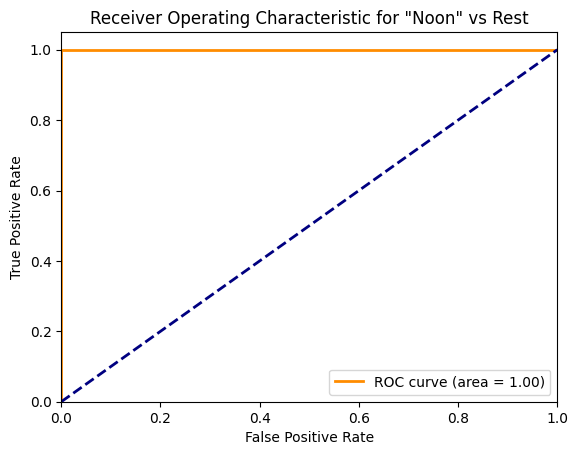

In [62]:
# Convert multiclass problem to binary by selecting one class vs the rest
noon_label = le_target.transform(['Noon'])[0]
binary_target = (y_test == noon_label).astype(int)  # Example: 'Noon' vs all other times

# Calculate ROC curve and AUC for the binary problem
fpr, tpr, thresholds = roc_curve(binary_target, model.predict_proba(X_test)[:, le_target.transform(['Noon'])[0]])
auc = roc_auc_score(binary_target, model.predict_proba(X_test)[:, noon_label])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for "Noon" vs Rest') # Update title
plt.legend(loc="lower right")
plt.show()

In [78]:
from operator import le
label_encoders = {
    'Weekday': le_weekday,
    'Hour': le_hour,
    'Country': le_country,
    'Customer_ID': le_customer_id,
}
def predict_time_of_day(quantity, spent, total_spent_by_invoice, weekday, hour, customer_id, invoice_no , country):
    input_data = pd.DataFrame({
        'Quantity': [quantity],
        'Spent': [spent],
        'TotalSpentByInvoice': [total_spent_by_invoice],
        'Weekday': [label_encoders['Weekday'].transform([weekday])[0] if weekday in label_encoders['Weekday'].classes_ else -1], # Handle unseen countries
        'Hour': [hour],
        'CustomerID': [label_encoders['Customer_ID'].transform([customer_id])[0] if customer_id in label_encoders['Customer_ID'].classes_ else -1],
        'InvoiceNo': [invoice_no],
        'Country': [label_encoders['Country'].transform([country])[0] if country in label_encoders['Country'].classes_ else -1], # Handle unseen countries
  })
    prediction = model.predict(input_data)
    return le_target.inverse_transform(prediction)[0]


# Example usage
predicted_time_of_day = predict_time_of_day(
    quantity=10,
    spent=59.9,
    total_spent_by_invoice=100.0,
    weekday='Monday',
    hour=18,
    customer_id='C12345',
    invoice_no='563653',
    country='United Kingdom'
)

print('Predicted TimeOfDay:',predicted_time_of_day)

Predicted TimeOfDay: Evening


In [36]:
features = ['Hour' , 'Frequency' , 'TotalSpentByInvoice' , 'TimeOfDay','CustomerID' , 'InvoiceNo' , 'Spent']
target =  'NoOfuniqueCountries'

le_country = LabelEncoder()
data['Hour'] = le_country.fit_transform(data['Hour'])
data['TimeOfDay'] = le_target.fit_transform(data['TimeOfDay'])
data['CustomerID'] = le_customer_id.fit_transform(data['CustomerID'])
data['InvoiceNo'] = le_invoice_no.fit_transform(data['InvoiceNo'])

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test).round()

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print('R2 Score:',r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:',mae)

Mean Squared Error: 3.0865504243031956
R2 Score: 0.867697476501817
Mean Absolute Error: 0.9478766271145526


In [37]:
y_pred = y_pred.flatten()
y_test_values = y_test.values

Results = pd.DataFrame({
    'Date': data.index[-len(y_test):],
    'Actual': y_test_values,
    'Predicted': y_pred
})

print(Results)

         Date  Actual  Predicted
0      215408       5        6.0
1      215409      11       11.0
2      215410       3        2.0
3      215411       3        3.0
4      215412       1        2.0
...       ...     ...        ...
53848  269256       1        4.0
53849  269257      11       10.0
53850  269258      12       12.0
53851  269259       5        5.0
53852  269260       4        5.0

[53853 rows x 3 columns]


In [42]:
from operator import le
label_encoders = {

    'Country': le_country,
    'TimeOfDay': le_target,
    'Hour': le_hour,
    'CustomerID': le_customer_id,
    'InvoiceNo': le_invoice_no

}
def predict_no_of_unique_countries(hour , frequency , total_spent_by_invoice , time_of_day , customer_id , invoice_no , spent):
    input_data = pd.DataFrame({
        'Hour': [hour],
        'Frequency': [frequency],
        'TotalSpentByInvoice': [total_spent_by_invoice],
        'TimeOfDay':  [label_encoders['TimeOfDay'].transform([time_of_day])[0]] if time_of_day in label_encoders['TimeOfDay'].classes_ else -1,
        'CustomerID': [label_encoders['CustomerID'].transform([customer_id])[0] if customer_id in label_encoders['CustomerID'].classes_ else -1],
        'InvoiceNo': [label_encoders['InvoiceNo'].transform([invoice_no])[0] if invoice_no in label_encoders['InvoiceNo'].classes_ else -1],
        'Spent': [spent],

    })
    prediction = model.predict(input_data)
    rounded_prediction = round(prediction[0])
    return rounded_prediction


# Example usage
predicted_no_of_unique_countries = predict_no_of_unique_countries(
    hour=18,
    frequency=3,
    total_spent_by_invoice=100.0,
    time_of_day='Morning',
    customer_id='C12345',
    invoice_no='563653',
    spent=59.9

)

print('Predicted NoOfUniqueCountries:', predicted_no_of_unique_countries)


Predicted NoOfUniqueCountries: 9


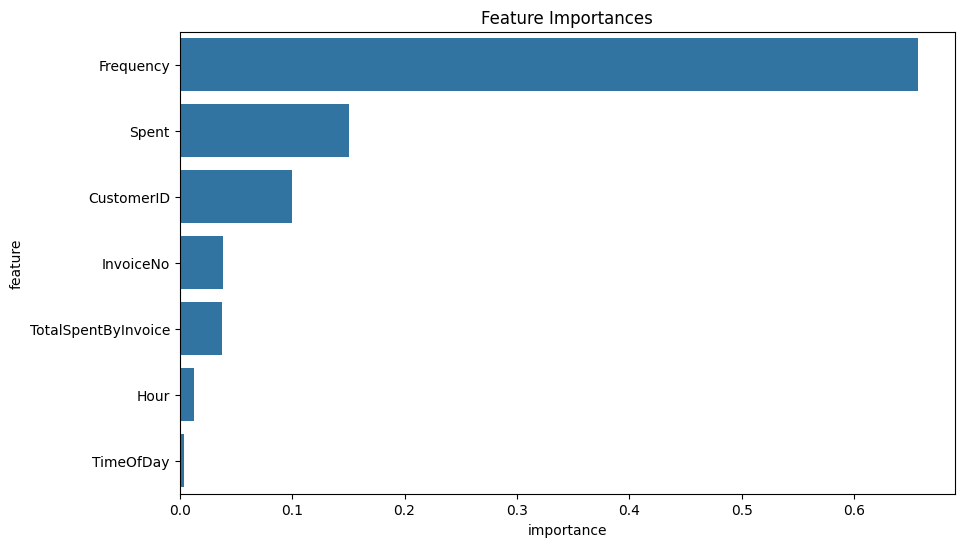

In [45]:
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


In [43]:
scenarios = [
    {'Hour': 10, 'Frequency': 3, 'TotalSpentByInvoice': 1000, 'TimeOfDay': 'Morning', 'CustomerID': 12345, 'InvoiceNo': 1, 'Spent': 500},
    {'Hour': 15, 'Frequency': 4, 'TotalSpentByInvoice': 1500, 'TimeOfDay': 'Evening', 'CustomerID': 67890, 'InvoiceNo': 2, 'Spent': 800},
    # Add more scenarios as needed
]

# Predict NoOfUniqueCountries for each scenario
for scenario in scenarios:
    predicted_no_of_unique_countries = predict_no_of_unique_countries(
        hour=scenario['Hour'],
        frequency=scenario['Frequency'],
        total_spent_by_invoice=scenario['TotalSpentByInvoice'],
        time_of_day=scenario['TimeOfDay'],
        customer_id=scenario['CustomerID'],
        invoice_no=scenario['InvoiceNo'],
        spent=scenario['Spent']
    )
    print(f"Scenario: {scenario}")
    print(f"Predicted NoOfUniqueCountries: {predicted_no_of_unique_countries}\n")

Scenario: {'Hour': 10, 'Frequency': 3, 'TotalSpentByInvoice': 1000, 'TimeOfDay': 'Morning', 'CustomerID': 12345, 'InvoiceNo': 1, 'Spent': 500}
Predicted NoOfUniqueCountries: 12

Scenario: {'Hour': 15, 'Frequency': 4, 'TotalSpentByInvoice': 1500, 'TimeOfDay': 'Evening', 'CustomerID': 67890, 'InvoiceNo': 2, 'Spent': 800}
Predicted NoOfUniqueCountries: 13



In [32]:
# Example: Each unique country adds an estimated revenue of $10,000
estimated_revenue_per_country = 10000
current_no_of_unique_countries = 47
predicted_increase_in_countries = predicted_no_of_unique_countries - current_no_of_unique_countries
estimated_revenue_increase = predicted_increase_in_countries * estimated_revenue_per_country

print(f"Estimated Revenue Increase: ${estimated_revenue_increase}")


Estimated Revenue Increase: $-280000


<ipython-input-50-e513fa222a2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='TimeOfDay', palette="muted")


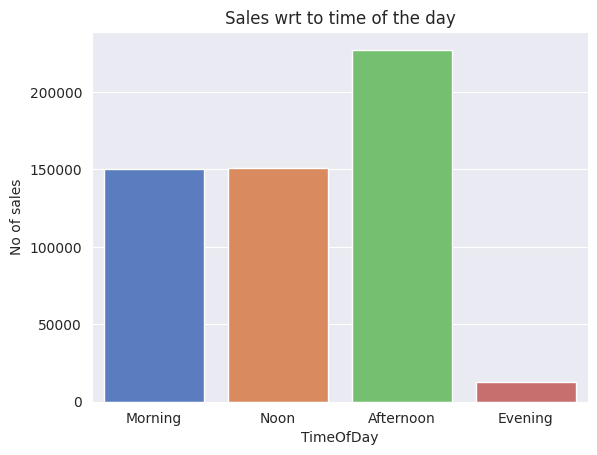

In [ ]:
sns.set_style("darkgrid")
sns.countplot(data=data, x='TimeOfDay', palette="muted")
plt.xlabel("TimeOfDay")
plt.ylabel("No of sales")
plt.title("Sales wrt to time of the day")
plt.show()

<ipython-input-21-d3489684cf8a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Weekday', palette="dark") #0=mon


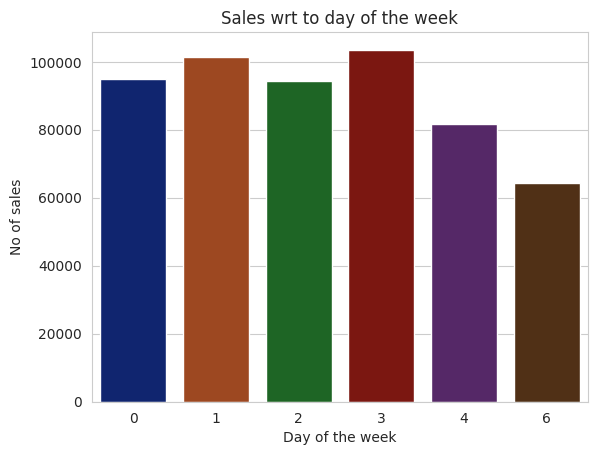

In [ ]:
sns.set_style("whitegrid")
sns.countplot(data=data, x='Weekday', palette="dark") #0=mon
plt.xlabel("Day of the week")
plt.ylabel("No of sales")
plt.title("Sales wrt to day of the week")
plt.show()

In [34]:
top_selling_product_by_country = country_product_sales.loc[country_product_sales.groupby('Country')['CountryProductSales'].idxmax()]
print(top_selling_product_by_country)

                    Country                          Description  \
221               Australia              MINI PAINT SET VINTAGE    
573                 Austria     SET 12 KIDS COLOUR  CHALK STICKS   
594                 Bahrain           ICE CREAM SUNDAE LIP GLOSS   
862                 Belgium      PACK OF 72 RETROSPOT CAKE CASES   
1081                 Brazil                 DOLLY GIRL LUNCH BOX   
1208                 Canada           RETRO COFFEE MUGS ASSORTED   
1432        Channel Islands                         RAIN PONCHO    
1644                 Cyprus       HEART DECORATION PAINTED ZINC    
1828         Czech Republic  COLOUR GLASS T-LIGHT HOLDER HANGING   
1897                Denmark                    GUMBALL COAT RACK   
2072                   EIRE                ASSORTED INCENSE PACK   
3331     European Community          OFFICE MUG WARMER CHOC+BLUE   
3348                Finland          60 TEATIME FAIRY CAKE CASES   
4160                 France              MINI PA